# Batsmen Probabilities
This notebook will develop probabilities for a batsmen to score runs, as well as get out.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import yaml
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

% matplotlib inline

## Read in One Game Data

In [2]:
with open('./ipl/1178410.yaml') as f:
    data = yaml.load(f.read())

In [3]:
print(yaml.dump(data))

info:
  city: Kolkata
  competition: IPL
  dates: ['2019-04-19']
  gender: male
  match_type: T20
  outcome:
    by: {runs: 10}
    winner: Royal Challengers Bangalore
  overs: 20
  player_of_match: [V Kohli]
  teams: [Kolkata Knight Riders, Royal Challengers Bangalore]
  toss: {decision: field, winner: Kolkata Knight Riders}
  umpires: [IJ Gould, Nitin Menon]
  venue: Eden Gardens
innings:
- 1st innings:
    deliveries:
    - 0.1:
        batsman: PA Patel
        bowler: HF Gurney
        non_striker: V Kohli
        runs: {batsman: 0, extras: 0, total: 0}
    - 0.2:
        batsman: PA Patel
        bowler: HF Gurney
        extras: {wides: 1}
        non_striker: V Kohli
        runs: {batsman: 0, extras: 1, total: 1}
    - 0.3:
        batsman: PA Patel
        bowler: HF Gurney
        non_striker: V Kohli
        runs: {batsman: 1, extras: 0, total: 1}
    - 0.4:
        batsman: V Kohli
        bowler: HF Gurney
        non_striker: PA Patel
        runs: {batsman: 0, extras: 0

## Kernel Density
Our first method is that for each batsman, we calculate probabilities of them scoring anywhere from 0 to 6 runs. These are only runs that can be scored off the bat. So any wides or extras are not counted here. Those would fall on the bowler, which we will take care of in the future.

From the ball by ball deliveries, we can determine the discrete chances of scoring the runs. However, in cricket it's extremely rare for a batsmen to score 3 or 5 runs. In some cases, there would be no instances of this during the game. For this reason, we do a sort of smoothing to the probablities. We can think of the runs scored as a random variable.

Kernel Density Estimation (KDE) is a way to estimate the probability distribution of a discrete random variable. It is almost like predicting the population probabilities from a small sample size. 

### Discrete Probabilities
First, we need to go through and collect all of the instances for each batsmen of scoring runs

In [4]:
# Initialize dictionary which holds 
# batsmen runs scored. The keys are the names,
# while the values are 7-element lists, which
# holds the number of times the batsmen has scored
# 0, 1, ..., 6 runs.
batsmenRunsScored = defaultdict(lambda: np.zeros(7, dtype=int))

In [5]:
# Ball-by-ball data is in the 'innings'
for innings in data['innings']:
    for values in innings.values():
        # 'deliveries' holds the ball-by-ball data we want.
        # Each element is a one-key dictionary holding the
        # delivery.
        for delivery in values['deliveries']:
            # Get the one element value.
            delivery = next(iter(delivery.values()))
            # 'batsman' holds the person who hit.
            # 'runs' has 'extras', 'total', and 'batsman'.
            # We want runs scored by batsman.
            runsScored = delivery['runs']['batsman']
            # Update dictionary
            batsmenRunsScored[delivery['batsman']][runsScored] += 1

Now let's see how the batsmen fared in this game!

In [6]:
for key, value in batsmenRunsScored.items():
    print(key, value)

PA Patel [7 3 0 0 2 0 0]
V Kohli [12 26  7  0  9  0  4]
AD Nath [8 7 0 0 0 0 1]
MM Ali [ 8 10  0  0  5  0  6]
MP Stoinis [4 3 0 0 2 0 1]
CA Lynn [1 1 0 0 0 0 0]
SP Narine [10  2  0  0  4  0  0]
Shubman Gill [7 2 0 1 1 0 0]
RV Uthappa [17  5  0  0  1  0  0]
N Rana [16 13  3  0  9  0  5]
AD Russell [16  3  0  0  2  0  9]


Wonderful! From this output we can see how many times each batsman scored 0, 1, 2, ..., 6 runs. For example, Virat Kohli had 12 times where he didn't take a run, 26 times he's run once, 7 times run twice, 9 fours, and 4 sixes. Notice only once did a batsman (Shubman Gill) scored 3 runs off one ball. Additionally, no one scored 5 runs off one ball.

This does not mean that the probability of scoring 5 runs is zero, however! With our small sample sign (one game), it is unlikely that someone will score 5 runs. However, there is bound to be at least one instance if we take all of the previous IPL matches dating back to 2008.

I will now show how using KDE can allow us to calculate probabilities of instances that haven't happened using Kohli's stats in this game. First, let's see a histogram.

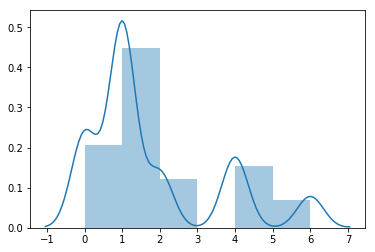

In [7]:
# Seaborn's distplot needs the individual points...
individRunRes = []
for run, count in enumerate(batsmenRunsScored['V Kohli']):
    individRunRes.extend([run] * count)

sns.distplot(individRunRes, bins=[0, 1, 2, 3, 4, 5, 6])

In [8]:
kernel = stats.gaussian_kde(individRunRes, )

In [9]:
kernel(6)

array([0.03859958])

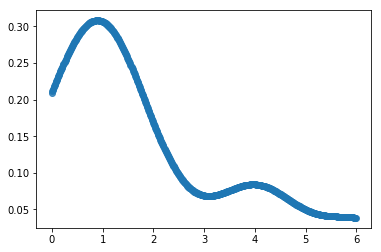

In [10]:
sns.regplot(x=np.arange(0,6,0.01), y=kernel(np.arange(0,6,0.01)), fit_reg=False)

So, as you can see here, the probability of scoring zero or one run is much more than those of the rest. However, due to the small sample size, the probability of scoring 6 runs is less than that of scoring 5 runs. Let's now loop through all IPL games we have, and repeat the process we did above for each file, and examine Kohli's stats once more. Additionally, we also need to save the number of times a player has gotten out. Thus, the default dictionary definition will change slightly to include two keys `'runs'` and `'outs'`.

In [11]:
# Glob can easily loop through all yaml files
import glob

In [12]:
# Remake the default dictionary object
batsmenRunsScored = defaultdict(lambda: dict(runs=np.zeros(7, dtype=int), outs=0))
for filepath in glob.iglob('ipl/*.yaml'):
    # Read the file
    with open(filepath) as f:
        data = yaml.load(f.read())
    # Gather stats
    # Ball-by-ball data is in the 'innings'
    for innings in data['innings']:
        for values in innings.values():
            # 'deliveries' holds the ball-by-ball data we want.
            # Each element is a one-key dictionary holding the
            # delivery.
            for delivery in values['deliveries']:
                # Get the one element value.
                delivery = next(iter(delivery.values()))
                # 'batsman' holds the person who hit.
                # 'runs' has 'extras', 'total', and 'batsman'.
                # We want runs scored by batsman.
                runsScored = delivery['runs']['batsman']
                # Update dictionary
                batsmenRunsScored[delivery['batsman']]['runs'][runsScored] += 1
                # Check if a player got out and add to the count.
                if 'wicket' in delivery.keys():
                    # Have to use player_out here, because a run-out
                    # could have happened where the non-striker got out.
                    batsmenRunsScored[delivery['wicket']['player_out']]['outs'] += 1

That took a while since it has to go through all the games from IPL's inception back in 2008. However, now we have all stats for all players.

In [13]:
batsmenRunsScored['V Kohli']

{'outs': 142, 'runs': array([1507, 1724,  292,   11,  480,    0,  190])}

Even with all those games, he only scored 3 runs 11 times, and has never scored 5 runs. He has way more 4s than 2s, which is impressive. Now let's see extrapolated probabilities.

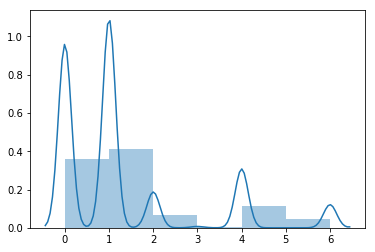

In [14]:
# Seaborn's distplot needs the individual points...
individRunRes = []
for run, count in enumerate(batsmenRunsScored['V Kohli']['runs']):
    individRunRes.extend([run] * count)

sns.distplot(individRunRes, bins=[0, 1, 2, 3, 4, 5, 6])

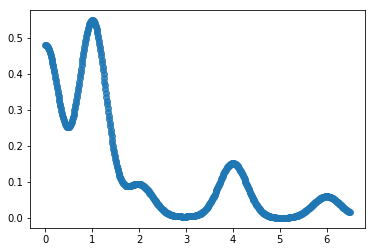

In [15]:
kernel = stats.gaussian_kde(individRunRes)
sns.regplot(x=np.arange(0,6.5,0.01), y=kernel(np.arange(0,6.5,0.01)), fit_reg=False)

In [16]:
kernel(np.arange(7))

array([0.4804325 , 0.54940792, 0.09474195, 0.0044024 , 0.15238967,
       0.00079015, 0.06031578])

Notice now that scoring a 5 is much less. It's almost zero, but NOT zero itself, and that's the key thing here. Similarly, scoring 3 runs is about half a percent. The graph shows that as well.

Next, we also need to see how often a player gets out.

In [17]:
batsmenRunsScored['V Kohli']['outs'] / np.sum(batsmenRunsScored['V Kohli']['runs'])

0.03377735490009515

Okay, so Kohli gets out about 3.4% of the time. Notice that this is higher than the probability of him scoring 3 or 5 runs, and only marginally smaller than him scoring a 6. Shall we do simulations?

## Batting Simulations
So now that we have probabilities of scoring runs, and probabilities of getting out, we can now simulate a batsmen's run scoring throughout a match. First, I'll deal with one batsmen at a time, then we'll take an entire squad and see how they perform as two batsmen rotate strike and others come in as they get out.

### One Batsman's Simulation
I'll take Virat Kohli because he is the leader of runs and he is one of the few that has been present since the very beginning. The procedure is simple: Each ball (up to a maximum of 120 balls i.e. 20 overs), we first see if he gets out (using the 3% chance from above). If he doesn't get out, then we see how many runs he has scored using the weighted probabilities.

One thing of note is that I am assuming he faces every single delivery, which is practically impossible. This is inevitable when I am trying to simulate solely one batsman. Once we bring in multiple batsman, the scores will start to look a tad more realistic. Additionally, there is actually a very low chance ~1% that he stays not out through the whole 120 deliveries.

I will rely heavily on `numpy`'s `random.choice` method, as that supports probability distributions. That method returns an error if the probabilities don't sum to one, so I'll be reweighting them (dividing by sum).

In [18]:
kohliRunProbs = kernel(np.arange(7)) / np.sum(kernel(np.arange(7)))
kohliOutProb = batsmenRunsScored['V Kohli']['outs'] / np.sum(batsmenRunsScored['V Kohli']['runs'])
simulations = 1000   # Number of simulations
# We will want to graph his run scores later, so save them.
runSimuls = []
for _ in range(simulations):
    currSimul = []
    runsScored = 0
    # Keep going until he gets out or 120 deliveries
    # is up.
    i = 1
    # Generates 0 if he's out, which evaluates to False.
    while i <= 120 and np.random.choice(2, 1, p=[kohliOutProb, 1 - kohliOutProb])[0]:
        # Get how many runs he scored.
        delivRun = np.random.choice(7, 1, p=kohliRunProbs)[0]
        runsScored += delivRun
        # Append it to currSimul
        currSimul.append(runsScored)
        i += 1
    # He got out, which is 0 runs, so append result.
    # Out first ball
    if len(currSimul) == 0:
        currSimul.append(0)
    else:
        currSimul.append(currSimul[-1])
    # Append this simulation to our list.
    runSimuls.append(currSimul)

In [19]:
runSimuls[0][-1], len(runSimuls[0])

(24, 26)

Excellent! The above output shows Kohli got to a score of 44 off 35 deliveries before getting out. Now we can work on plotting each of these simulations on one graph to see a range. The `lineplot` function of `seaborn` will do the trick. However, for that, we need to make a `DataFrame` where we have one column each for the delivery, the runs scored, and which simulation it is. In this way, we can specify the `hue='simulation'` parameter of the function and `seaborn` will automatically color the lines for us.

### Plotting the Simulations

In [20]:
# First count total # of deliveries
# across all simulations
numOfDeliveries = sum([len(simul) for simul in runSimuls])
# Create the df with that many rows
kohliDF = pd.DataFrame(data=np.zeros((numOfDeliveries, 3), dtype=int), columns=['delivery', 'runs', 'simulation'])
rowIndex = 0
# For each simulation, set the runs scored for each delivery.
for i, simul in enumerate(runSimuls, 1):
    for ball, run in enumerate(simul, 1):
        kohliDF.loc[rowIndex] = [ball, run, i]
        # Go to the next row
        rowIndex += 1

In [21]:
kohliDF.head()

,delivery,runs,simulation
0,1,0,1
1,2,0,1
2,3,0,1
3,4,4,1
4,5,4,1


In [22]:
kohliDF.tail()

,delivery,runs,simulation
28694,4,6,999
28695,5,7,999
28696,6,7,999
28697,7,7,999
28698,1,0,1000


Notice that the first part of the `DataFrame` has the first deliveries of the 1st simulation, while the last couple of rows contain the 1000th simulation. Now we're ready to plot!

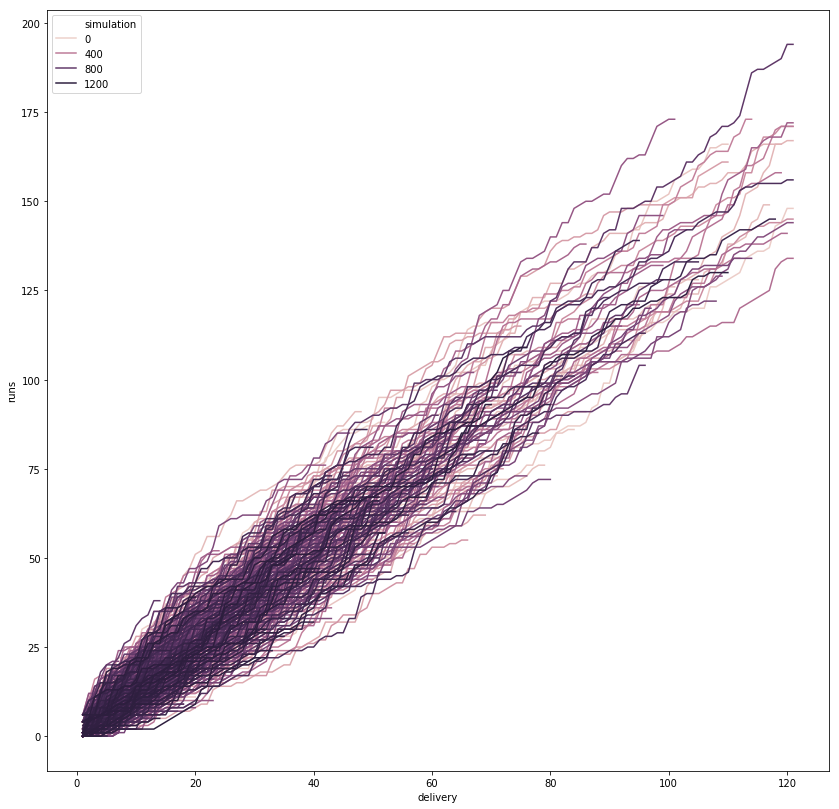

In [23]:
plt.figure(figsize=(14,14))
sns.lineplot(x='delivery', y='runs', hue='simulation', data=kohliDF, estimator=None)

You can see that the number of times he's gotten not out after 120 balls is pretty small. I counted 19 times, which equate to 19/1000 ~ 2%. Also, a couple of times the score has screamed past 100, and even scraping the barrier of an unfathomable 200. Overall, this visualization looks pleasing, almost like a hairy purple comet. :)

## Squad Simulation
Okay, now that we have simulated runs scored for one person, it is time to take a squad of players and see how many runs they score in 20 overs. Some assumptions will have to be made here:

- The batting order will be fixed from the start. This means that once someone gets out, the next batter in line will start batting. In other words, I am not handling run outs where a new batsman comes in at the striker's end and faces the very next ball.
- I will also handle odd # of runs, where the non-striker runs to the striker's end and faces the next ball.
- Batsmen will also switch ends between overs.
- Extras which result in an additional ball such as wides and no-balls will not be handled, like with the single batsman case.

### Creating Kernels
With a squad, we need 11 separate kernel density estimators for each of the 11 players. The squad I will use is the 2019 Royal Challengers Bangalore squad which resulted in consistent performance (throughout the otherwise horrible season):

- PA Patel
- V Kohli
- AB de Villiers
- MM Ali
- AD Nath
- MP Stoinis
- P Negi
- N Saini
- UT Yadav
- DW Steyn
- YS Chahal

The above list also shows the batting order as well. Since we'll want to test with different squads eventually, we'll just calculate kernel and out probabilities for everyone we have. However, there is a slight hitch. It is possible that some batsmen would have faced an extremely low amount of deliveries. This can happen if he is a bowler and thus won't come until everyone else has gotten out. Therefore, the kernel estimation will only be done for batsmen who have faced at least 30 balls in our dataset. For those who have faced fewer than 30, we will set them according to the average of the rest.

In practice, a smarter thing to do would be to set them to be the average probabilities for batsmen who have batted at that spot, but we are trying to keep things simple.

In [27]:
# We can keep the probabilities as keys in the batsmen's dictionary 
# entries. While we are at it, let's just do it for everyone in the
# set shall we.
# Kernel probabilities will be in a key called kernelProb, while
# out probabilities will be outProb.
lowBallsFaced = []
for player, statistics in batsmenRunsScored.items():
    # Create array of each instance of run result,
    # since gaussian_kde needs it.
    individRunRes = []
    for run, count in enumerate(statistics['runs']):
        individRunRes.extend([run] * count)
    
    # Only calculate kernel if balls faced is at least 30
    if len(individRunRes) < 30:
        lowBallsFaced.append(player)
        continue
    # Create kernel
    kernel = stats.gaussian_kde(individRunRes)
    # Calculate probabilities and reweight so it
    # sums to one.
    kernelProbs = kernel(np.arange(7))
    kernelProbs /= np.sum(kernelProbs)
    
    # Calculate out probabilities for this batsman
    outProb = statistics['outs'] / np.sum(statistics['runs'])
    
    # Set them in the dictionary entry
    statistics['kernelProbs'] = kernelProbs
    statistics['outProb'] = outProb

Now we have to calculate the average probabilities for the batsmen who have faced fewer than 30 balls.

In [38]:
# Use numpy to quickly find average.
averageRunProbs = np.mean(np.array([batsmenRunsScored[player]['kernelProbs'] for player in batsmenRunsScored.keys() 
                             if player not in lowBallsFaced]), axis=0)
# Find average probabilitiy of getting out.
averageOutProb = np.mean([batsmenRunsScored[player]['outProb'] for player in batsmenRunsScored.keys() 
                              if player not in lowBallsFaced])
# Go through each player and set the keys...
for player in lowBallsFaced:
    batsmenRunsScored[player]['kernelProbs'] = averageRunProbs
    batsmenRunsScored[player]['outProb'] = averageOutProb

In [39]:
lowBallsFaced[:5]

['TS Mills', 'A Choudhary', 'Vishnu Vinod', 'A Zampa', 'Imran Tahir']

As I thought, the list appears to be either bowlers (Zampa and Tahir) or players whose career in the IPL was not very long. Ideally, we would take other bowlers who are slightly better at batting and use those averages, but as I said before, simplicity is good to start.

### Innings Simulation
Okay, now that we have kernel and out probabilities for all players in our dataset, it's time to simulate a match! As stated before, no extras are allowed, and if a player gets out, then the next player in the batting order faces the next ball. For example, Parthiv and Kohli open batting for RCB, if Parthiv gets out, then AB de Villiers will face the next ball. Also, ones, threes, and maybe an occasional five will rotate strike as usual. Strike rotation also takes place between overs.

In [63]:
batsmenOrder = ['PA Patel', 'V Kohli', 'AB de Villiers', 'MM Ali', 'AD Nath', 
               'MP Stoinis', 'P Negi', 'N Saini', 'UT Yadav', 'DW Steyn', 'YS Chahal']
striker = batsmenOrder[0]
nonStriker = batsmenOrder[1]
inAt = 2
# Start with 0, we'll ignore this first value later.
runs = [0]
# 20 overs, 6 balls each = 120 balls
for ball in range(1, 121):
    print(str((ball-1) // 6) + '.' + str((ball-1) % 6 + 1) + ':', striker, end=' ')
    # See if the striker gets out.
    outResult = np.random.choice(2, 1, p=[batsmenRunsScored[striker]['outProb'], 
                                          1 - batsmenRunsScored[striker]['outProb']])[0]
    # 0 means out, 
    if outResult == 0:
        print('OUT! ==>', runs[-1])
        # Scored 0 runs, have the next batter come in.
        # If we're out of batters, then the innings are over.
        if inAt == 11:
            break
        # Scored 0 runs this ball, so add that
        runs.append(runs[-1])
        # Next batter becomes striker next ball.
        striker = batsmenOrder[inAt]
        inAt += 1
        # Go to next ball
        continue
    # Otherwise, batsmen isn't out, so see how much he scored.
    runsScored = np.random.choice(7, 1, p=batsmenRunsScored[striker]['kernelProbs'])[0]
    runs.append(runs[-1] + runsScored)
    print(runsScored, '==>', runs[-1])
    # If the number of runs scored was odd, then switch striker and non-striker 
    # for the next ball.
    if runsScored % 2 == 1:
        temp = striker
        striker = nonStriker
        nonStriker = temp
    # If it's the last ball of the over,
    # then switch striker and non-striker.
    if ball % 6 == 0:
        temp = striker
        striker = nonStriker
        nonStriker = temp

0.1: PA Patel 0 ==> 0
0.2: PA Patel 0 ==> 0
0.3: PA Patel 1 ==> 1
0.4: V Kohli 4 ==> 5
0.5: V Kohli 1 ==> 6
0.6: PA Patel 4 ==> 10
1.1: V Kohli 1 ==> 11
1.2: PA Patel 2 ==> 13
1.3: PA Patel 4 ==> 17
1.4: PA Patel 0 ==> 17
1.5: PA Patel 4 ==> 21
1.6: PA Patel 4 ==> 25
2.1: V Kohli 0 ==> 25
2.2: V Kohli 2 ==> 27
2.3: V Kohli 1 ==> 28
2.4: PA Patel 1 ==> 29
2.5: V Kohli 0 ==> 29
2.6: V Kohli 1 ==> 30
3.1: V Kohli 1 ==> 31
3.2: PA Patel 0 ==> 31
3.3: PA Patel 3 ==> 34
3.4: V Kohli 2 ==> 36
3.5: V Kohli 1 ==> 37
3.6: PA Patel 1 ==> 38
4.1: PA Patel 1 ==> 39
4.2: V Kohli 1 ==> 40
4.3: PA Patel 0 ==> 40
4.4: PA Patel 1 ==> 41
4.5: V Kohli 2 ==> 43
4.6: V Kohli 0 ==> 43
5.1: PA Patel 0 ==> 43
5.2: PA Patel 6 ==> 49
5.3: PA Patel 1 ==> 50
5.4: V Kohli 0 ==> 50
5.5: V Kohli 1 ==> 51
5.6: PA Patel 0 ==> 51
6.1: V Kohli 6 ==> 57
6.2: V Kohli 4 ==> 61
6.3: V Kohli 0 ==> 61
6.4: V Kohli 1 ==> 62
6.5: PA Patel 0 ==> 62
6.6: PA Patel OUT! ==> 62
7.1: AB de Villiers 1 ==> 63
7.2: V Kohli 1 ==> 64
7.3: 